In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
import math
import matplotlib.pyplot as plt
from torchsummaryX import summary

from pathlib import Path


In [5]:
dataset_path = Path().resolve().parent/'dataset/HomeC.csv'
df = pd.read_csv(dataset_path)
dataset_path

WindowsPath('C:/Users/ngxin/projects/Capstone-Project-Time-Series-Forecasting/dataset/HomeC.csv')

In [6]:
# clean data 
#remove kW
df.columns = [i.replace(' [kW]', '') for i in df.columns]
#combine similar objects
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#remove unused objects; icon and summary are objects that cannot be passed into calculation; use column same as House overall column and gen column same as Solar column
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary','Solar'],axis = 1,inplace = True)
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
#replace object in cloudCover with float
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
#set date time as index and drop time column
date_time = pd.date_range('2016-01-01 00:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [7]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability', 'Furnace', 'Kitchen'],
      dtype='object')

In [8]:
# Since the dataset has both energy and weather data, it is better we seperate them to do the resample method on them separately
energy_data = df[['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen']]
energy_data

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,0.000967,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,0.000933,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,0.001000,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,0.000950,1.116033,0.000650


In [9]:
# aggregate the data in minutes into data in days 
data_per_hour = energy_data.resample("H").mean()
data_per_day = data_per_hour.resample("D").sum()
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405


<AxesSubplot:>

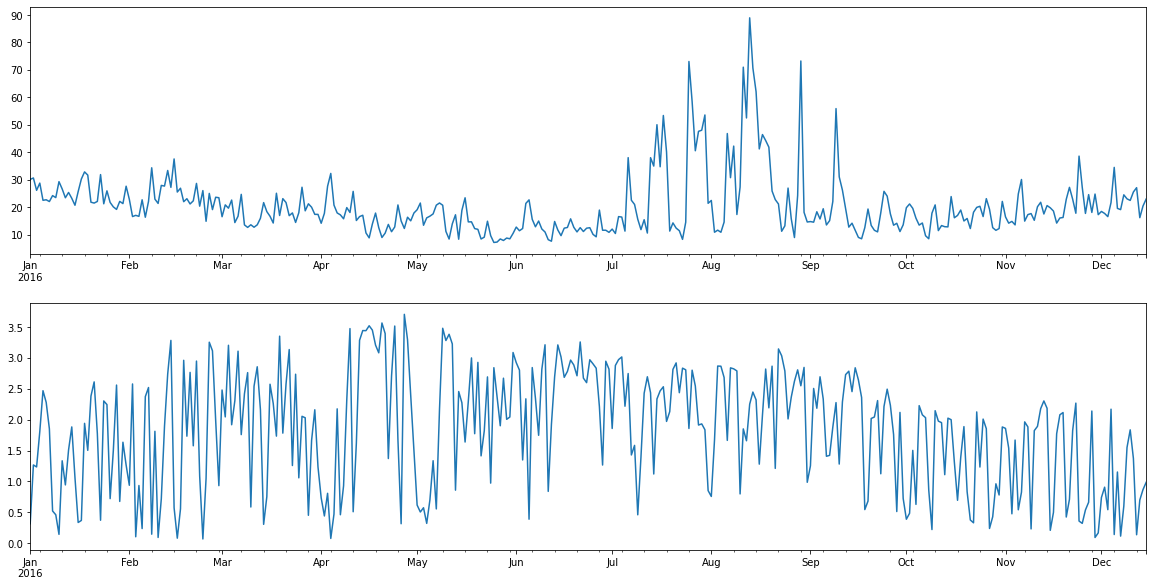

In [10]:
fig, axes = plt.subplots(nrows=2, ncols =1)
data_per_day["use"].plot(ax=axes[0],figsize = (20,10))
data_per_day["gen"].plot(ax=axes[1],figsize = (20,10))

In [11]:
weather_data = df[['temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability']]

In [12]:
weather_per_day = weather_data.resample("D").mean()
# In this notebook, we are not going to use weather data

# Splitting

In [13]:
split_ratio = 0.70
num_epochs = 100
window_size = 6
batch_size = 10
learning_rate = 0.001
n_step = 1 

In [14]:
split_data = round(len(data_per_day.use)*split_ratio)
split_data

245

In [15]:
train_data = data_per_day.use.values[:split_data]
test_data = data_per_day.use.values[split_data:]
train_time = data_per_day.use.index[:split_data]
test_time = data_per_day.use.index[split_data:]

# Standardization

In [16]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.reshape(-1, 1))
print(f"train_data_standard :{train_data_standard.shape}")

train_data_standard :(245, 1)


# Sequencing 

In [17]:
def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [18]:
trainX ,trainY =  univariate_single_step(train_data_standard,window_size)
testX , testY = univariate_single_step(test_data_standard,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(239, 6, 1) trainY shape:(239, 1)

testX shape:(99, 6, 1) testY shape:(99, 1)


In [19]:
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [20]:
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Configure model

In [21]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers,n_step):
            super(LSTM, self).__init__()
            
            # Number of feature of data
            self.n_feature = n_feature
            
            # Hidden unit dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers
            
            # Number of step ,step =1 -> single step forecast
            self.n_step = n_step 
          

            # Building your LSTM
            # batch_first=True 
            # Configuration -> (number of feature , number of hidden unit,number of layer)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, n_step)
            ### END SOLUTION

        def forward(self, x):
            ### BEGIN SOLUTION
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # Initialize cell state with zeros
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # we just want last time step hidden states(output)
            out = out[:, -1, :]
            out = self.fc(out)
            
            return out

In [22]:
torch.manual_seed(123)

hidden_dim = 100
number_of_time_series = 1 
n_step = 1 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1 

# Vanila , Stacked LSTM
model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim,num_layers=num_layers,n_step = n_step)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))

       Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                               
0_lstm            -  [10, 6, 100]   41200      40400
1_fc       [100, 1]       [10, 1]     101        100
----------------------------------------------------
                      Totals
Total params           41301
Trainable params       41301
Non-trainable params       0
Mult-Adds              40500
       Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                               
0_lstm            -  [10, 6, 100]   41200      40400
1_fc       [100, 1]       [10, 1]     101        100


# Training

In [24]:
def training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cumulative sum 
        running_loss_train = 0
        running_loss_valid = 0
        
        # For loop to loop through each data in the data iterator
        for _,(train_X,train_Y) in enumerate(train_iter):
            
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between batches
            optimizer.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimizer.step()
            
            # Since the loss_train.item will only return the average loss based number of batches
            # loss_train.item()*train_X.size(0) -> to make it multiply with batch size 
            running_loss_train += loss_train.item()*train_X.size(0)
            
        # Average the loss base on total batch size ,train_iter.dataset is use to get the total batch size 
        epoch_loss_train = running_loss_train /len(train_iter.dataset)
        # Store the averaged value
        train_loss[t] = epoch_loss_train
        
        # Validate the test data loss
        with torch.no_grad():
            # For loop to loop through each data in the data iterator
            for j,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                
                # Calculate the loss 
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each batch
                running_loss_valid += loss_test.item()*test_X.size(0)
                
        # Average the loss base on total batch size 
        epoch_loss_test =running_loss_valid /len(test_iter.dataset)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
        
    return train_loss,val_loss

In [25]:
torch.manual_seed(123)
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model)

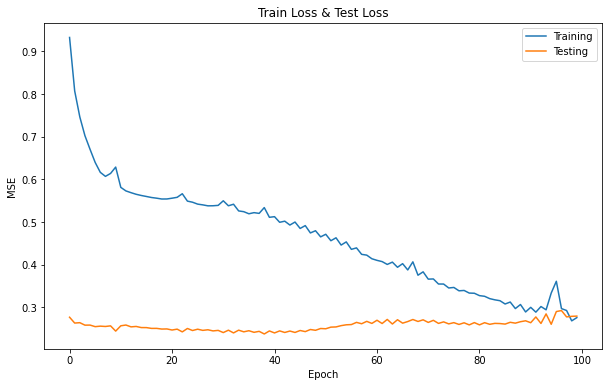

Epoch : 0 , training loss : 0.932567021338012 , validation loss : 0.2766612320385798
Epoch : 1 , training loss : 0.8071196036857541 , validation loss : 0.26297556541182776
Epoch : 2 , training loss : 0.7462722137882121 , validation loss : 0.26385463804307613
Epoch : 3 , training loss : 0.7022926424587123 , validation loss : 0.25806598034169936
Epoch : 4 , training loss : 0.6702757482124672 , validation loss : 0.2582323988429224
Epoch : 5 , training loss : 0.639526927072134 , validation loss : 0.2545644634149291
Epoch : 6 , training loss : 0.6163160750431994 , validation loss : 0.2557305396355764
Epoch : 7 , training loss : 0.6068948802214786 , validation loss : 0.2549747665873682
Epoch : 8 , training loss : 0.6137416524243654 , validation loss : 0.25642132751568397
Epoch : 9 , training loss : 0.6286710294345432 , validation loss : 0.24412193623456088
Epoch : 10 , training loss : 0.5810729982214493 , validation loss : 0.2565461052487595
Epoch : 11 , training loss : 0.5727758892971602 , 

In [26]:
def learning_curve(num_epochs,train_loss,val_loss):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Testing")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Train Loss & Test Loss")
    plt.show()
    for i in range(num_epochs):
        print(f'Epoch : {i} , training loss : {train_loss[i]} , validation loss : {val_loss[i]}')
    
learning_curve(num_epochs,train_loss,val_loss)


# Evaluation

In [27]:
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

# Section 2 : Reshape to original data
y_train_prediction= torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [28]:
y_train_prediction= scaler.inverse_transform(y_train_prediction.numpy())
y_train = scaler.inverse_transform(trainY.numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.numpy())
y_test = scaler.inverse_transform(testY.numpy())

In [29]:
print("Test Data\t\t\tForecast Data")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

Test Data			Forecast Data
[22.143995]		[17.758423]
[55.92051]		[20.37443]
[31.093063]		[31.843323]
[26.265614]		[34.940533]
[19.478168]		[25.876429]
[12.805151]		[24.498953]
[14.238505]		[13.148706]
[11.60059]		[17.21341]
[9.062435]		[14.138372]
[8.560781]		[19.111328]
[12.607384]		[10.060046]
[19.388186]		[17.128996]
[13.424515]		[16.328157]
[11.655507]		[12.110921]
[11.0731325]		[14.081124]
[18.043322]		[12.165703]
[25.823387]		[21.483475]
[24.067722]		[19.510046]
[17.619747]		[22.14607]
[13.501431]		[15.701524]
[14.20245]		[11.493498]
[11.193003]		[15.373265]
[13.633001]		[16.296856]
[19.871006]		[20.341991]
[21.227245]		[16.3751]
[19.633356]		[20.056879]
[16.05309]		[18.730177]
[13.543327]		[13.887391]
[14.303307]		[11.52872]
[9.674247]		[17.176487]
[8.580954]		[16.968878]
[17.891344]		[16.180016]
[20.889013]		[17.515745]
[11.537128]		[16.947786]
[13.37198]		[13.186672]
[12.956438]		[15.559651]
[12.894581]		[9.6888075]
[23.916496]		[20.117334]
[16.203495]		[20.876778]
[17.052404]		

In [30]:
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.34 RMSE
Test Score: 6.69 RMSE


# Plot forecast data

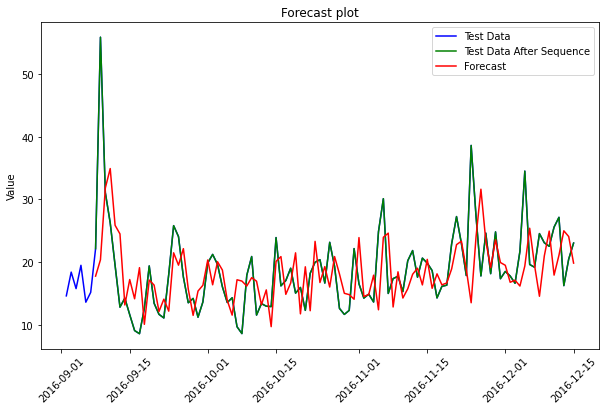

In [31]:
def single_step_plot(original_test_data,sequence_test_data,forecast_data,test_time,window_size,original_plot =False):
    
    # Take the time index after data sequence
    sequence_test_time = test_time[window_size:]
    
    plt.figure(figsize=(10,6))
    
    if original_plot:
        plt.plot(test_time,original_test_data,color="blue",label = 'Test Data')
        
    plt.plot(sequence_test_time,sequence_test_data,color="green", label = 'Test Data After Sequence')
    plt.plot(sequence_test_time,forecast_data,color="red", label = 'Forecast')
    plt.xticks(rotation = 45)
    plt.ylabel("Value")
    plt.title("Forecast plot")
    plt.legend()

single_step_plot(original_test_data = test_data,
                 sequence_test_data = y_test,
                 forecast_data = y_test_prediction,
                 test_time = test_time,
                 window_size = window_size,
                 original_plot = True)   